<a href="https://colab.research.google.com/github/Dias04404/sistemas-energia-eolica/blob/main/Atividade_05_Caico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Estimativa dos parâmetros e cálculo da Potência*

## DataSet

In [12]:
#### IMPORTAR BIBLIOTECAS ####
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore') # Ignora warnings no github
from IPython.display import Image

#### SCIPY ####
from scipy.special import gamma
from scipy.optimize import minimize
from scipy.stats import weibull_min
from scipy.optimize import minimize_scalar


#### IMPORTAR DADOS NASA ####
from google.colab import drive
drive.mount('/content/drive')
pasta = '/content/drive/MyDrive/eolica/nasa' # DEFINIR PASTA COM OS CSVs

#### CRIA LISTAS ####
arquivos = [f for f in os.listdir(pasta) if f.lower().endswith('.csv')]
lista_df = [] # LISTA COM DATAFRAMES

#### PROCESSAR ARQUIVOS ####
for arquivo in arquivos:
    caminho = os.path.join(pasta, arquivo)
    try:
        df = pd.read_csv(
                caminho,
                skiprows= 13,
                #encoding='latin1',
                sep=',',
                decimal='.',
                on_bad_lines='skip'
            )
        df = df.loc[:, ~df.columns.duplicated()]


    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")


#### EXIBIR INFOS FINAIS ####
print("Colunas finais:", df.columns.tolist())
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Colunas finais: ['YEAR', 'MO', 'DY', 'HR', 'WS10M', 'WD10M', 'PS', 'WD50M', 'WS50M']


,YEAR,MO,DY,HR,WS10M,WD10M,PS,WD50M,WS50M
0,2014,1,1,0,6.57,100.0,97.76,100.1,8.66
1,2014,1,1,1,6.04,101.2,97.72,101.2,8.07
2,2014,1,1,2,5.62,102.7,97.69,102.8,7.63
3,2014,1,1,3,5.32,105.0,97.68,104.8,7.40
4,2014,1,1,4,5.06,106.2,97.70,106.0,7.20
...,...,...,...,...,...,...,...,...,...
96427,2024,12,31,19,6.41,85.9,97.55,86.0,8.64
96428,2024,12,31,20,6.44,84.1,97.67,84.4,8.56
96429,2024,12,31,21,7.28,86.5,97.76,86.8,9.53
96430,2024,12,31,22,7.63,90.2,97.81,90.4,9.70


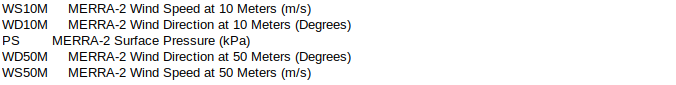

In [13]:
df.describe(include='all')

,YEAR,MO,DY,HR,WS10M,WD10M,PS,WD50M,WS50M
count,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000,96432.000000
mean,2019.000747,6.522648,15.730463,11.500000,5.404905,109.441078,97.878338,109.720122,7.119962
std,3.162491,3.448798,8.800486,6.922222,1.828705,26.437946,0.229628,26.182425,1.988983
min,2014.000000,1.000000,1.000000,0.000000,0.070000,0.000000,96.980000,0.000000,0.130000
25%,2016.000000,4.000000,8.000000,5.750000,4.030000,95.300000,97.730000,95.800000,5.810000
50%,2019.000000,7.000000,16.000000,11.500000,5.360000,111.500000,97.880000,111.800000,7.090000
75%,2022.000000,10.000000,23.000000,17.250000,6.760000,125.300000,98.030000,125.400000,8.470000
max,2024.000000,12.000000,31.000000,23.000000,11.010000,359.800000,98.630000,359.800000,13.610000


# Tarefa 12

Traçar a curva de potencia de 2 tipos diferentes de turbinas e falar sobre suas características e fazer um estudo de potência usando o weibull calculado nas atividades passadas em uma região.

**Caicó e Mossoró**

*   2015
*   2024

**Métodos Escolhidos:**


- Método da Energia Padrão
    
- Método do Momento

- Método da Máxima Verossimilhança
    


In [14]:
v_filtrados = df["WS50M"].dropna().values
# Método da Energia Padrão

import numpy as np
from scipy.special import gamma
from scipy.optimize import minimize

# Lista os valores de velocidade
velocidades = np.array(v_filtrados)

# Cálculo da energia observada
energia_obs = np.mean(velocidades ** 3)
media_obs = np.mean(velocidades)

# Função de erro: diferença entre energia e média teórica e observada
def erro_energia(params):
    k, c = params
    if k <= 0 or c <= 0:
        return np.inf
    energia_teo = c**3 * gamma(1 + 3 / k)
    media_teo = c * gamma(1 + 1 / k)
    erro_energia = (energia_obs - energia_teo)**2
    erro_media = (media_obs - media_teo)**2
    return erro_energia + erro_media  # ou pesar diferente se preferir

# Estimativa inicial
res = minimize(erro_energia, x0=[2.0, 5.0], bounds=[(0.5, 10), (0.5, 20)])

k_energia, c_energia = res.x
print(f"Estimativa pelo Método da Energia Padrão -> k: {k_energia:.4f}, c: {c_energia:.4f}")


# Método do Momento


from scipy.special import gamma
from scipy.optimize import minimize_scalar

media = np.mean(velocidades)
variancia = np.var(velocidades)

def erro_momento(k):
    if k <= 0: return np.inf
    g1 = gamma(1 + 1/k)
    g2 = gamma(1 + 2/k)
    c_estimado = media / g1
    var_teorica = c_estimado**2 * (g2 - g1**2)
    return (variancia - var_teorica)**2

res = minimize_scalar(erro_momento, bounds=(0.1, 10), method='bounded')
k_mom = res.x
c_mom = media / gamma(1 + 1/k_mom)

print(f"Estimativa Método dos Momentos -> k: {k_mom:.4f}, c: {c_mom:.4f}")


# Método da Máxima Verossimilhança


import numpy as np
from scipy.stats import weibull_min


# Lista os valores de velocidade
velocidades = np.array(v_filtrados)

# Estimativa de parâmetros via MLE
shape_k, loc, scale_c = weibull_min.fit(velocidades, floc=0)  # loc fixado em 0

print(f"Estimativa MLE -> k (forma): {shape_k:.4f}, c (escala): {scale_c:.4f}")


Estimativa pelo Método da Energia Padrão -> k: 4.0090, c: 7.8541
Estimativa Método dos Momentos -> k: 4.0189, c: 7.8531
Estimativa MLE -> k (forma): 3.9760, c (escala): 7.8511


-------

## Tarefa 13 - Weibull

Calcular a produtividade para cada caso visto na Tarefa 7, utilizando as duas distribuições colocadas nesses slides (Rayleigh e Weibull), considerando os 3 diferentes metodos utilizados e as duas localidades e dois anos diferentes.

## A partir de dados de fabricantes

Traçar a curva de potencia de 2 tipos diferentes de turbinas e falar sobre suas características e fazer um estudo de potência usando o weibull calculado nas atividades passadas em uma região.

TURBINA 01:
    
    AERODAN 75/15
    Manufacturer: AERODAN
    Model: 75/15
    Rated power: 75 kW
    Rotor diameter: 17 m
    Swept area: 227 m²
    Number of blades: 3
    Power control: Pitch
    Commissioning: não disponível

    Rotor:
    Minimum rotor speed: não informado
    Maximum rotor speed: 48.4 rd/min
    Cut-in wind speed: 5 m/s
    Rated wind speed: ~12 m/s
    Cut-off wind speed: 23 m/s
    Manufacturer: não informado

- Gearbox:
  2 stages, ratio 1:21, Valmet

- Generator:
  Type: induction
  Maximum speed: 1,016.0 U/min
  Voltage: 415 V
  Manufacturer: --

- Tower:
  Hub height: 23 m
https://en.wind-turbine-models.com/turbines/1378-aerodan-75-15#powercurve

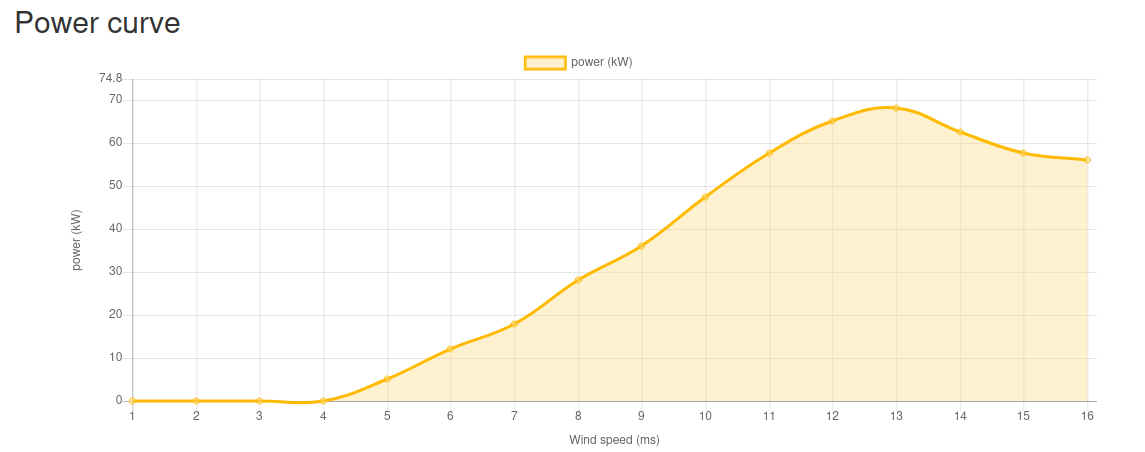

In [15]:
def CpLambdaModels(Model,TSR,Beta=[]):

    #vSources=['Slootweg et al. 2003','Heier 2009','Thongam et al. 2009','De Kooning et al.  2010','Ochieng et Manyonge 2014','Dai et al. 2016','constant']

    TSR=np.maximum(0.0001,TSR)

    if Beta==[]:
        Beta=np.zeros(TSR.shape)
    if Model=='constant':
        Cp=np.ones(TSR.shape)*0.49
    else:
        if Model=='Slootweg et al. 2003':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.73,151,0.58,0,0.002,13.2,18.4,0,-0.02,0.003
            x=2.14
        elif  Model=='Heier 2009':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5,116,0.4,0,0,5,21,0,0.089,0.035
            x=0
        elif  Model=='Thongam et al. 2009':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5176,116,0.4,0,0,5,21,0.006795,0.089,0.035
            x=0
        elif  Model=='De Kooning et al. 2010':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.77,151,0,0,0,13.65,18.4,0,0,0
            x=0
        elif  Model=='Ochieng et Manyonge 2014':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.5,116,0,0.4,0,5,21,0,0.08,0.035
            x=0
        elif  Model=='Dai et al. 2016':
            c1,c2,c3,c4,c5,c6,c7,c8,c9,c10=0.22,120,0.4,0,0,5,12.5,0,0.08,0.035
            x=0

        Li=1/(1/(TSR+c9*Beta)-c10/(Beta**3+1));
        Cp=np.maximum(0,c1*(c2/Li-c3*Beta-c4*Li*Beta-c5*Beta**x-c6)*np.exp(-c7/Li)+c8*TSR);

    return Cp

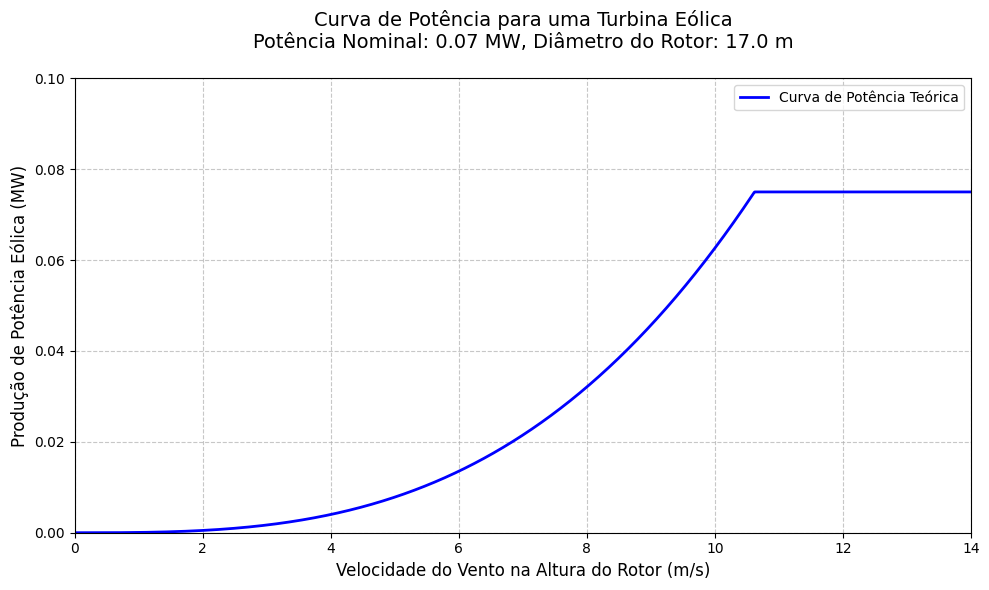

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def WT_PowerCurve_raw(Vws,Pnom,D,rMin=[],rMax=[],CpMax=[],Model='Dai et al. 2016',Beta=[],AirDensity=1.225,ConvEff=0.92):
    Rrotor = D/2
    Arotor = np.pi*Rrotor**2

    # r ==> Velocidade Angular
    if isinstance(rMin, list) and not rMin:
        rMin_val = 188.8*D**(-0.7081)   # rpm
    else:
        rMin_val = rMin

    if isinstance(rMax, list) and not rMax:
        rMax_val = 793.7*D**(-0.8504)      #  rpm
    else:
        rMax_val = rMax

    VtipMin=rMin_val*(2*np.pi*Rrotor)/60   # m/s
    VtipMax=rMax_val*(2*np.pi*Rrotor)/60  # m/s

    vTSR=np.arange(0,12,0.001)
    vCp=CpLambdaModels(Model,vTSR,Beta)
    TSR_Opt=np.mean(vTSR[vCp==np.max(vCp)]) # arrays

    if isinstance(CpMax, list) and not CpMax: # Verifica se CpMax é uma lista vazia
        CpScale=1
        CpMax_val=np.max(vCp)
    else:
        CpScale=CpMax/np.max(vCp)
        CpMax_val = CpMax # Usar o valor passado se não for lista vazia

    # Calcula a tip speed
    Vtip=np.minimum(VtipMax,np.maximum(VtipMin,TSR_Opt*Vws))
    TSR=np.zeros(Vws.shape)
    TSR[Vws>0]=Vtip[Vws>0]/Vws[Vws>0]

    # Calcula o coefi de potencia
    Cp0=np.maximum(0,ConvEff*CpScale*CpLambdaModels(Model,TSR))

    # Calcula p ent
    Pin=0.5*AirDensity*Arotor*(Vws**3)/1000
    Cp=np.zeros(Pin.shape)
    # Evita divisão por zero se Pin for 0
    Cp[Pin>0]=np.minimum(Cp0[Pin>0],Pnom/Pin[Pin>0])
    Pout = Cp*Pin

    return Pout

# --- Parâmetros da turbina ---
rMin_param    = 5 # m/s
rMax_param    = 12 # m/s
D_param       = 17 # m
Pnom_param    = 75 # kW


Vws_teorico = np.arange(0, 15, 0.01) # De 0 a 15 m/s com passos de 0.01

# Calcula a curva de potência usando o Vws teórico
Pwt_teorico = WT_PowerCurve_raw(Vws_teorico, Pnom_param, D_param,
                               rMin=rMin_param, rMax=rMax_param, CpMax=[],
                               Model='constant', AirDensity=1.225)

plt.figure(figsize=(10, 6)) # Define o tamanho do gráfico
plt.plot(Vws_teorico, Pwt_teorico / 1000, color='blue', linewidth=2, label='Curva de Potência Teórica') # Plota a curva teórica

plt.grid(True, linestyle='--', alpha=0.7) # Grade mais suave
plt.xlabel('Velocidade do Vento na Altura do Rotor (m/s)', fontsize=12)
plt.ylabel('Produção de Potência Eólica (MW)', fontsize=12)
plt.title(f'Curva de Potência para uma Turbina Eólica\n'
          f'Potência Nominal: {Pnom_param/1000:.2f} MW, Diâmetro do Rotor: {D_param:.1f} m\n',
          fontsize=14)

plt.xlim(0, 14) # Ajusta o limite do eixo X para o intervalo relevante (0 a 14 m/s como na imagem)
plt.ylim(0, 0.1) # Ajusta o limite do eixo Y para a potência em MW (0 a 0.1 MW como na imagem)

plt.xticks(np.arange(0, 15, 2)) # Marcas no eixo X de 2 em 2
plt.yticks(np.arange(0, 0.11, 0.02)) # Marcas no eixo Y de 0.02 em 0.02

plt.legend(fontsize=10) # Adiciona legenda se você plotar mais de uma série
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

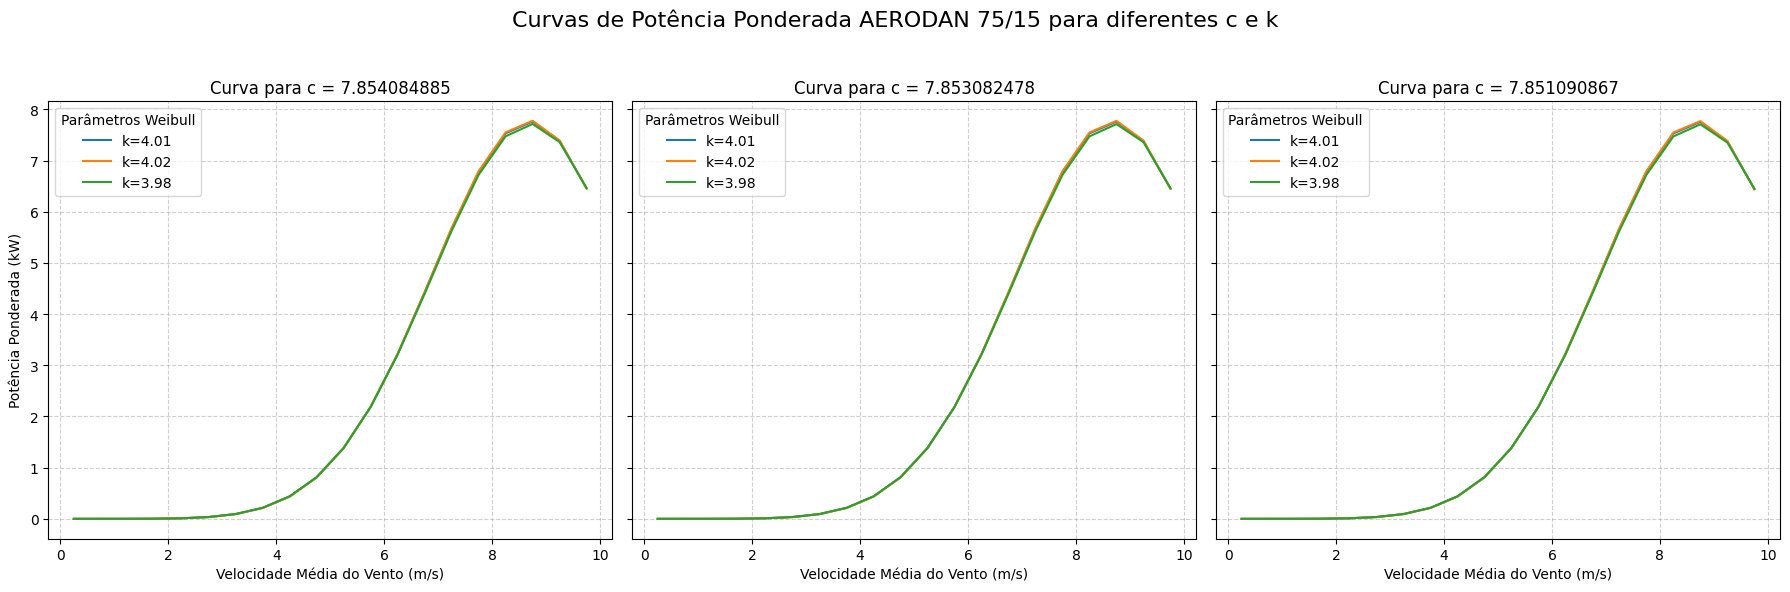

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dados de velocidade (assuma que v_filtrados está definido)
velocidades = v_filtrados

# Parâmetros da turbina Siemens ACSA (Espanha) A29/225
D = 29  # diâmetro do rotor em metros
A = 661 # área varrida em m² (fornecida)
T = 25  # temperatura ambiente em °C
rho = (353.4 * (1 - (171.26 / 45271))**5.2624) / (273.15 + T)
Cp = 0.4  # coeficiente de potência típico
Ui = 5
Uf = 23
Um = 12

# Valores estimados pelos métodos Tarefa 07
c_values = [c_energia, c_mom, scale_c]
k_values = [k_energia, k_mom, shape_k]

def prob_weibull_faixa(Ui, Uf, c, k):
    return np.exp(-((Ui / c) ** k)) - np.exp(-((Uf / c) ** k))

def potencia_turbina(v, rho, A, Cp):
    if v < Ui or v > Uf:
        return 0
    elif v >= Um:
        return 2300  # potência nominal da turbina
    else:
        return 0.5 * rho * A * Cp * v**3 / 1000  # em kW
# Faixas
limites = np.arange(0, 10.5, 0.5)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, c in enumerate(c_values):
    ax = axs[idx]

    for k in k_values:
        velocidades_plot = []
        potencias_ponderadas = []

        for i in range(len(limites) - 1):
            Ui = limites[i]
            Uf = limites[i + 1]
            v_med = (Ui + Uf) / 2

            p_faixa = prob_weibull_faixa(Ui, Uf, c, k)
            p_turbina = potencia_turbina(v_med, rho, A, Cp)
            pot_ponderada = p_faixa * p_turbina

            velocidades_plot.append(v_med)
            potencias_ponderadas.append(pot_ponderada)

        ax.plot(velocidades_plot, potencias_ponderadas, label=f'k={round(k, 2)}')

    ax.set_title(f'Curva para c = {round(c, 9)}')
    ax.set_xlabel('Velocidade Média do Vento (m/s)')
    if idx == 0:
        ax.set_ylabel('Potência Ponderada (kW)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="Parâmetros Weibull")

plt.suptitle("Curvas de Potência Ponderada AERODAN 75/15 para diferentes c e k", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

TURBINA 02:
    
    Manufacturer: AWP A/S (Dinamarca)
    Model: AWP 90/18
    Rated power: 90 kW
    Rotor diameter: 18.6 m
    Swept area: 270.0 m²
    Specific area: 3 m²
    Number of blades: 3
    Rated power: 90.0 kW
      
    Rotor:
    Cut-in wind speed: 4 m/s
    Rated wind speed: 13 m/s
    Cut-off wind speed: 25 m/s
    Survival speed: 57 m/s
    Manufacturer: AWP A/S

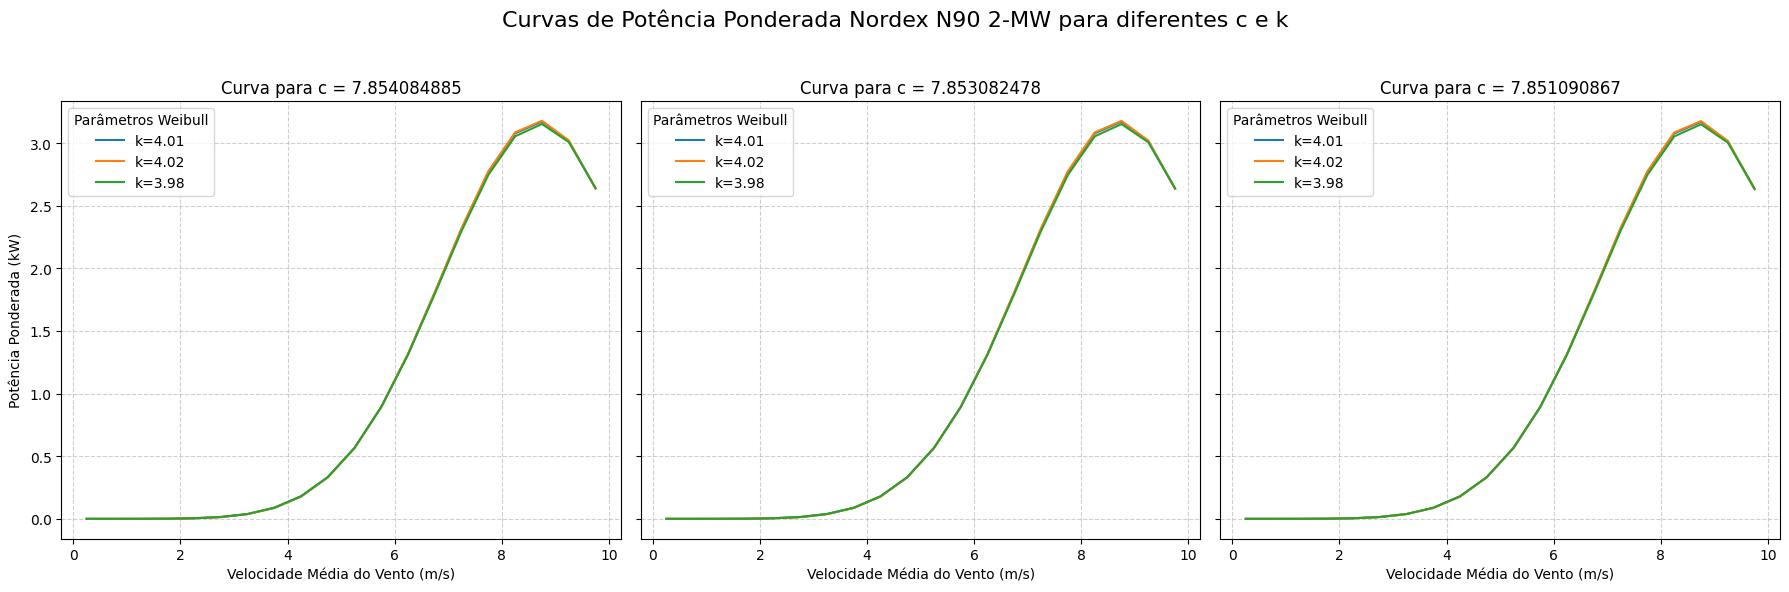

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dados de velocidade (assuma que v_filtrados está definido)
velocidades = v_filtrados

# Parâmetros da turbina Nordex N90 2-MW
D = 18.6 # diâmetro do rotor em metros
A = 270 # área varrida em m² (fornecida)
T = 25  # temperatura ambiente em °C
rho = (353.4 * (1 - (171.26 / 45271))**5.2624) / (273.15 + T)
Cp = 0.4  # coeficiente de potência típico
Ui = 4
Uf = 25
Um = 13

# Valores estimados pelos métodos Tarefa 07
c_values = [c_energia, c_mom, scale_c]
k_values = [k_energia, k_mom, shape_k]

def prob_weibull_faixa(Ui, Uf, c, k):
    return np.exp(-((Ui / c) ** k)) - np.exp(-((Uf / c) ** k))

def potencia_turbina(v, rho, A, Cp):
    if v < Ui or v > Uf:
        return 0
    elif v >= Um:
        return 90  # potência nominal da turbina
    else:
        return 0.5 * rho * A * Cp * v**3 / 1000  # em kW
# Faixas
limites = np.arange(0, 10.5, 0.5)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, c in enumerate(c_values):
    ax = axs[idx]

    for k in k_values:
        velocidades_plot = []
        potencias_ponderadas = []

        for i in range(len(limites) - 1):
            Ui = limites[i]
            Uf = limites[i + 1]
            v_med = (Ui + Uf) / 2

            p_faixa = prob_weibull_faixa(Ui, Uf, c, k)
            p_turbina = potencia_turbina(v_med, rho, A, Cp)
            pot_ponderada = p_faixa * p_turbina

            velocidades_plot.append(v_med)
            potencias_ponderadas.append(pot_ponderada)

        ax.plot(velocidades_plot, potencias_ponderadas, label=f'k={round(k, 2)}')

    ax.set_title(f'Curva para c = {round(c, 9)}')
    ax.set_xlabel('Velocidade Média do Vento (m/s)')
    if idx == 0:
        ax.set_ylabel('Potência Ponderada (kW)')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(title="Parâmetros Weibull")

plt.suptitle("Curvas de Potência Ponderada Nordex N90 2-MW para diferentes c e k", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

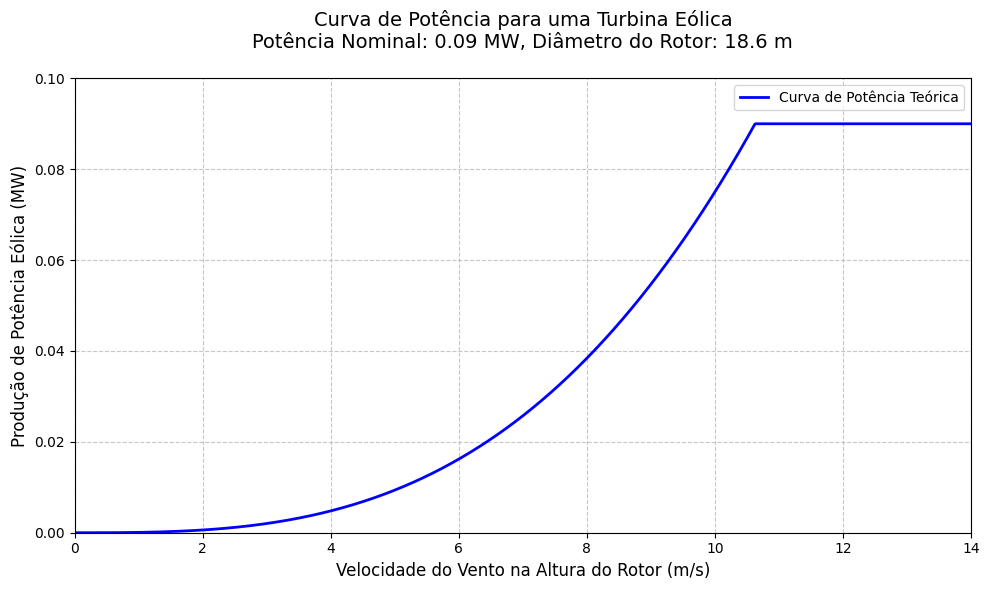

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def WT_PowerCurve_raw(Vws,Pnom,D,rMin=[],rMax=[],CpMax=[],Model='Dai et al. 2016',Beta=[],AirDensity=1.225,ConvEff=0.92):
    Rrotor = D/2
    Arotor = np.pi*Rrotor**2

    if isinstance(rMin, list) and not rMin:
        rMin_val = 188.8*D**(-0.7081)   # minimal angular speed in rpm
    else:
        rMin_val = rMin

    if isinstance(rMax, list) and not rMax:
        rMax_val = 793.7*D**(-0.8504)      # maximal angular speed in rpm
    else:
        rMax_val = rMax

    VtipMin=rMin_val*(2*np.pi*Rrotor)/60   # minimal tip speed in m/s
    VtipMax=rMax_val*(2*np.pi*Rrotor)/60  # maximal tip speed in m/s

    vTSR=np.arange(0,12,0.001)
    vCp=CpLambdaModels(Model,vTSR,Beta)
    TSR_Opt=np.mean(vTSR[vCp==np.max(vCp)]) # Use np.max para arrays NumPy

    # scaling of the power coefficient function if a value is given for CpMax
    if isinstance(CpMax, list) and not CpMax: # Verifica se CpMax é uma lista vazia
        CpScale=1
        CpMax_val=np.max(vCp)
    else:
        CpScale=CpMax/np.max(vCp)
        CpMax_val = CpMax # Usar o valor passado se não for lista vazia

    # Calculation of the tip speed and the tip speed ratio
    Vtip=np.minimum(VtipMax,np.maximum(VtipMin,TSR_Opt*Vws))
    TSR=np.zeros(Vws.shape)
    TSR[Vws>0]=Vtip[Vws>0]/Vws[Vws>0]

    # Calculation of the power coefficient
    Cp0=np.maximum(0,ConvEff*CpScale*CpLambdaModels(Model,TSR))

    # Calculation of the input power as a function of air density, wind speed and rotor area
    Pin=0.5*AirDensity*Arotor*(Vws**3)/1000
    Cp=np.zeros(Pin.shape)
    # Evita divisão por zero se Pin for 0
    Cp[Pin>0]=np.minimum(Cp0[Pin>0],Pnom/Pin[Pin>0])
    Pout = Cp*Pin

    return Pout

# --- Parâmetros da turbina ---
rMin_param    = 4 # m/s
rMax_param    = 13 # m/s
D_param       = 18.6 # m
Pnom_param    = 90 # kW


Vws_teorico = np.arange(0, 15, 0.01) # De 0 a 15 m/s com passos de 0.01

# Calcula a curva de potência usando o Vws teórico
Pwt_teorico = WT_PowerCurve_raw(Vws_teorico, Pnom_param, D_param,
                               rMin=rMin_param, rMax=rMax_param, CpMax=[],
                               Model='constant', AirDensity=1.225)

plt.figure(figsize=(10, 6)) # Define o tamanho do gráfico
plt.plot(Vws_teorico, Pwt_teorico / 1000, color='blue', linewidth=2, label='Curva de Potência Teórica') # Plota a curva teórica

plt.grid(True, linestyle='--', alpha=0.7) # Grade mais suave
plt.xlabel('Velocidade do Vento na Altura do Rotor (m/s)', fontsize=12)
plt.ylabel('Produção de Potência Eólica (MW)', fontsize=12)
plt.title(f'Curva de Potência para uma Turbina Eólica\n'
          f'Potência Nominal: {Pnom_param/1000:.2f} MW, Diâmetro do Rotor: {D_param:.1f} m\n',
          fontsize=14)

plt.xlim(0, 14) # Ajusta o limite do eixo X para o intervalo relevante (0 a 14 m/s como na imagem)
plt.ylim(0, 0.1) # Ajusta o limite do eixo Y para a potência em MW (0 a 0.1 MW como na imagem)

plt.xticks(np.arange(0, 15, 2)) # Marcas no eixo X de 2 em 2
plt.yticks(np.arange(0, 0.11, 0.02)) # Marcas no eixo Y de 0.02 em 0.02

plt.legend(fontsize=10) # Adiciona legenda se você plotar mais de uma série
plt.tight_layout() # Ajusta o layout para evitar sobreposição
plt.show()

## Tarefa 13


Os alunos irão fazer a tabela anterior para duas localidades e dois anos diferentes e para 2 aerogeradores diferentes

In [22]:
print(df.columns)

Index(['YEAR', 'MO', 'DY', 'HR', 'WS10M', 'WD10M', 'PS', 'WD50M', 'WS50M'], dtype='object')


In [27]:
# para as duas turbinas e dois anos
# Parâmetros constantes
T = 25  # Temperatura em °C
rho = (353.4 * (1 - (171.26 / 45271))**5.2624) / (273.15 + T)  # Densidade do ar
limites = np.arange(0, 11, 1)  # Faixas de velocidade em m/s

def tratamento_para_diametro(D, velocidades, ano):
    A = (np.pi * D**2) / 4  # Área varrida
    contagens, _ = np.histogram(velocidades, bins=limites)
    total = len(velocidades)

    faixas = []
    probabilidades = []
    v_medios = []
    potencias = []
    pot_ponderada = []

    for i in range(len(contagens)):
        faixa = f"{limites[i]}–{limites[i+1]}"
        probabilidade = contagens[i] / total
        v_medio = ((limites[i] + limites[i+1]) / 2)
        potencia = 0.5 * rho * A * v_medio**3  # em watts

        faixas.append(faixa)
        probabilidades.append(round(probabilidade, 4))
        v_medios.append(round(v_medio, 2))
        potencias.append(round(potencia, 2))
        pot_ponderada.append(round(probabilidade * potencia, 2))

    df_resultado = pd.DataFrame({
        "Faixa (m/s)": faixas,
        "Probabilidade": probabilidades,
        "V_médio (m/s)": v_medios,
        "Potência (W)": potencias,
        "Potência Ponderada (W)": pot_ponderada
    })

    titulo = f"\n# TRATAMENTO PARA PLOTAGEM DA TABELA — Ano: {ano} | Turbina com D = {D} m"
    print(titulo)
    print(df_resultado.to_string(index=False))
    print("\n" + "-"*80 + "\n")

# Lista de anos e diâmetros a analisar
anos = [2015, 2024]
diametros = [17, 18.6]


# Loop principal
for ano in anos:
    df_ano = df[df['YEAR'] == ano]
    velocidades = df_ano['WS50M'].dropna().values

    if len(velocidades) == 0:
        print(f"\n⚠️ Nenhum dado disponível para o ano {ano}.\n")
        continue

    for D in diametros:
        tratamento_para_diametro(D, velocidades, ano)



# TRATAMENTO PARA PLOTAGEM DA TABELA — Ano: 2015 | Turbina com D = 17 m
Faixa (m/s)  Probabilidade  V_médio (m/s)  Potência (W)  Potência Ponderada (W)
        0–1         0.0002            0.5         16.48                    0.00
        1–2         0.0014            1.5        445.04                    0.61
        2–3         0.0103            2.5       2060.38                   21.17
        3–4         0.0280            3.5       5653.68                  158.12
        4–5         0.0568            4.5      12016.14                  683.11
        5–6         0.1221            5.5      21938.93                 2679.75
        6–7         0.1997            6.5      36213.24                 7230.25
        7–8         0.2031            7.5      55630.26                11297.51
        8–9         0.1712            8.5      80981.17                13866.64
       9–10         0.1161            9.5     113057.17                13125.47

----------------------------------------------

# Tarefa 14


In [29]:
# CALCULA EAG

def tratamento_para_diametro(D, velocidades, ano):
    A = (np.pi * D**2) / 4  # Área varrida
    contagens, _ = np.histogram(velocidades, bins=limites)
    total = len(velocidades)

    faixas = []
    probabilidades = []
    v_medios = []
    potencias = []
    pot_ponderada = []

    # Variáveis para cálculo da potência média
    pot_ponderada_total = 0  # Somatória das potências ponderadas
    potencia_maxima = 0  # Potência máxima para normalizar

    for i in range(len(contagens)):
        faixa = f"{limites[i]}–{limites[i+1]}"
        probabilidade = contagens[i] / total
        v_medio = ((limites[i] + limites[i+1]) / 2)
        potencia = 0.5 * rho * A * v_medio**3  # em watts

        # Somar potência ponderada para cálculo da potência média
        pot_ponderada_total += probabilidade * potencia

        # Armazenando valores para exibição
        faixas.append(faixa)
        probabilidades.append(round(probabilidade, 4))
        v_medios.append(round(v_medio, 2))
        potencias.append(round(potencia, 2))
        pot_ponderada.append(round(probabilidade * potencia, 2))

    # Potência média anual (em watts), convertendo para kW
    potencia_media_kW = pot_ponderada_total / 1000  # Potência média em kW

    # Convertendo a potência média para kWh por ano (multiplicando por 8760 horas no ano)
    energia_ano_kWh = potencia_media_kW * 8760

    # Exibindo a tabela com os resultados
    df_resultado = pd.DataFrame({
        "Faixa (m/s)": faixas,
        "Probabilidade": probabilidades,
        "V_médio (m/s)": v_medios,
        "Potência (W)": potencias,
        "Potência Ponderada (W)": pot_ponderada
    })

    # Exibindo a potência média anual
    print(f"Potência média anual para a turbina com D = {D} m em {ano}: {potencia_media_kW:.2f} kW")
    print(f"Energia anual gerada: {energia_ano_kWh:.2f} kWh")
    print("\n" + "-"*80 + "\n")

# Lista de anos e diâmetros a analisar
anos = [2015, 2024]
diametros = [18.6]

# Loop principal
for ano in anos:
    df_ano = df[df['YEAR'] == ano]
    velocidades = df_ano['WS50M'].dropna().values

    if len(velocidades) == 0:
        print(f"\n⚠️ Nenhum dado disponível para o ano {ano}.\n")
        continue

    for D in diametros:
        tratamento_para_diametro(D, velocidades, ano)
#########


Potência média anual para a turbina com D = 18.6 m em 2015: 58.73 kW
Energia anual gerada: 514497.26 kWh

--------------------------------------------------------------------------------

Potência média anual para a turbina com D = 18.6 m em 2024: 52.19 kW
Energia anual gerada: 457143.52 kWh

--------------------------------------------------------------------------------



In [32]:
# CALCULA O FATOR DE CAPACIDADE

# Valores fornecidos
Eag_2015 = 514497.26 # kWh (Energia anual gerada em 2015)
Eag_2024 = 457143.52  # kWh (Energia anual gerada em 2024)

# Potência nominal da turbina (assumindo 5 kW como exemplo)
P_nominal = 90  # kW

# Número de horas no ano (8760 horas)
horas_no_ano = 8760

# Cálculo do Fator de Capacidade para 2015
Fc_2015 = Eag_2015 / (horas_no_ano * P_nominal)
# Cálculo do Fator de Capacidade para 2024
Fc_2024 = Eag_2024 / (horas_no_ano * P_nominal)

# Exibindo os resultados
print(f"Fator de Capacidade para 2015: {Fc_2015:.4f}")
print(f"Fator de Capacidade para 2024: {Fc_2024:.4f}")


Fator de Capacidade para 2015: 0.6526
Fator de Capacidade para 2024: 0.5798



# TRATAMENTO PARA PLOTAGEM DA TABELA — Ano: 2015 | Turbina com D = 18.6 m
Faixa (m/s)  Probabilidade  V_médio (m/s)  Potência (W)  Potência Ponderada (W)
        0–1         0.0002            0.5         19.73                    0.00
        1–2         0.0014            1.5        532.76                    0.73
        2–3         0.0103            2.5       2466.47                   25.34
        3–4         0.0280            3.5       6767.99                  189.29
        4–5         0.0568            4.5      14384.44                  817.75
        5–6         0.1221            5.5      26262.94                 3207.92
        6–7         0.1997            6.5      43350.63                 8655.28
        7–8         0.2031            7.5      66594.62                13524.18
        8–9         0.1712            8.5      96942.03                16599.66
       9–10         0.1161            9.5     135339.99                15712.42

--------------------------------------------